In [1]:
%matplotlib inline

import os
import tarfile
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


df = load_housing_data()

# Looking at the basic characteristics of the dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Creating Train and Test datasets

In [5]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

# train - test split with stratification
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in test_split.split(df, df["income_cat"]):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

print(X_train["income_cat"].value_counts().sort_index() / len(X_train))
print(X_test["income_cat"].value_counts().sort_index() / len(X_test))

for set_ in (X_train, X_test):
    set_.drop("income_cat", axis=1, inplace=True)


income_cat
1    0.039789
2    0.318859
3    0.350594
4    0.176296
5    0.114462
Name: count, dtype: float64
income_cat
1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: count, dtype: float64


# Removing Outliers from Train dataset

In [6]:
attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

outlier_idx = set()
for attr in attr_list:
    lo = X_train[attr].quantile(0.005)
    hi = X_train[attr].quantile(0.995)
    mask = (X_train[attr] < lo) | (X_train[attr] > hi)
    outlier_idx.update(X_train.loc[mask].index.tolist())

outlier_idx = sorted(outlier_idx)
print(f"Removing {len(outlier_idx)} rows: {outlier_idx[:10]}{'...' if len(outlier_idx)>10 else ''}")

X_train = X_train.drop(index=outlier_idx).reset_index(drop=True)
y_train = y_train.drop(index=outlier_idx).reset_index(drop=True)

Removing 437 rows: [50, 57, 59, 66, 71, 78, 83, 87, 91, 320]...


# Filling nulls

In [7]:
sp = SimpleImputer(strategy="median").set_output(transform="pandas")

X_train['total_bedrooms'] = sp.fit_transform(X_train[['total_bedrooms']])
X_test['total_bedrooms'] = sp.transform(X_test[['total_bedrooms']])

# Creating new features

In [8]:
X_train["rooms_per_household"] = X_train["total_rooms"] / X_train["households"]
X_train["population_per_household"] = X_train["population"] / X_train["households"]
X_train["bedrooms_per_room"] = X_train["total_bedrooms"] / X_train["total_rooms"]
X_train["log_median_income"] = np.log1p(X_train["median_income"])
X_train["income_rooms"] = X_train["median_income"] * X_train["rooms_per_household"]
X_train["income_bedrooms"] = X_train["median_income"] * X_train.get("bedrooms_per_room", X_train["total_bedrooms"] / X_train["total_rooms"])
X_train["age_income"] = X_train["housing_median_age"] * X_train["median_income"]

X_test["rooms_per_household"] = X_test["total_rooms"] / X_test["households"]
X_test["population_per_household"] = X_test["population"] / X_test["households"]
X_test["bedrooms_per_room"] = X_test["total_bedrooms"] / X_test["total_rooms"]
X_test["log_median_income"] = np.log1p(X_test["median_income"])
X_test["income_rooms"] = X_test["median_income"] * X_test["rooms_per_household"]
X_test["income_bedrooms"] = X_test["median_income"] * X_test.get("bedrooms_per_room", X_test["total_bedrooms"] / X_test["total_rooms"])
X_test["age_income"] = X_test["housing_median_age"] * X_test["median_income"]


# Encoding String Columns

In [9]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

X_train_cat = ohe.fit_transform(X_train[["ocean_proximity"]])
X_test_cat = ohe.transform(X_test[["ocean_proximity"]])

X_train = pd.concat([X_train.drop("ocean_proximity", axis=1), X_train_cat], axis=1)
X_test = pd.concat([X_test.drop("ocean_proximity", axis=1), X_test_cat], axis=1)

# Scaling Values

In [10]:
ss = StandardScaler().set_output(transform="pandas")

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [11]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,log_median_income,income_rooms,income_bedrooms,age_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-0.939286,1.344653,0.014725,0.780126,0.813429,0.950226,0.712148,-0.946821,0.043787,0.110043,-0.125073,-1.051236,-0.641208,-1.274483,-0.654307,-0.889094,1.466746,-0.011155,-0.35532,-0.384773
1,1.174321,-1.193058,-1.757745,1.625591,0.983489,0.703842,0.911229,1.432408,0.744616,-0.162110,-0.875466,1.394485,1.382088,1.095550,-0.928663,-0.889094,-0.681781,-0.011155,-0.35532,2.598935
2,0.269917,-0.127500,1.223227,-0.537443,-0.614484,-0.792221,-0.591510,-0.546026,-0.001193,-0.362090,-0.361317,-0.468541,-0.414559,-0.844863,0.278155,-0.889094,1.466746,-0.011155,-0.35532,-0.384773
3,1.224288,-1.351957,-0.388109,-0.386112,-0.001683,-0.535848,-0.003900,-0.916650,-0.734095,-0.543966,1.052422,-1.003086,-0.848247,-0.576092,-0.795366,-0.889094,-0.681781,-0.011155,-0.35532,2.598935
4,0.439805,-0.636911,-0.146409,0.583221,0.370688,0.506291,0.307565,0.380478,0.340757,0.109387,-0.509537,0.551494,0.338867,0.278006,0.203265,1.124741,-0.681781,-0.011155,-0.35532,-0.384773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16070,1.254268,-1.221099,-1.193777,2.411457,2.085943,0.716050,1.659387,0.719674,0.613936,-0.461668,-0.476174,0.850765,0.748805,0.770290,-0.533453,1.124741,-0.681781,-0.011155,-0.35532,-0.384773
16071,-0.919299,1.339980,-1.113210,3.133637,2.645967,3.760338,2.998366,-0.580939,0.085653,0.207261,-0.554743,-0.514921,-0.403610,-1.029072,-0.960289,-0.889094,1.466746,-0.011155,-0.35532,-0.384773
16072,-1.568871,1.307265,1.545495,-1.069729,-1.036700,-1.024177,-1.002515,-0.371913,-0.625008,-0.142583,0.357958,-0.247655,-0.568690,-0.032687,0.662003,1.124741,-0.681781,-0.011155,-0.35532,-0.384773
16073,-1.558878,1.246510,-1.193777,0.360608,0.177172,-0.191798,0.053897,0.209051,0.438425,-0.268263,-0.490509,0.387706,0.276468,0.070498,-0.717261,1.124741,-0.681781,-0.011155,-0.35532,-0.384773


# Training Linear Regression

In [12]:
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

[65444.35371973 62763.55180462 65557.99593041 87806.40567108
 64860.09621887]
Mean: 69286.48066894017, Std: 9314.425804022532
Test RMSE: 68082.34549586158


# Training Decision Tree

In [13]:
tree_reg = DecisionTreeRegressor()

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

[72894.12347361 73241.5773484  70628.58454138 71827.28410354
 72353.29679293]
Mean: 72188.97325197437, Std: 916.2801332840093
Test RMSE: 71311.76490695361


In [14]:
# forest_reg = RandomForestRegressor()

# scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print(rmse_scores)
# print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

# forest_reg.fit(X_train, y_train)
# y_pred = forest_reg.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Test RMSE: {rmse}")

# Test RMSE: 49838.58791670875

In [15]:
# # param_grid = [
# #     {'n_estimators': [10, 30, 50, 100], 'max_features': [2, 4, 6, 8], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10]},
# #     {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 6]},
# # ]

# # Max score: 49159.6
# # param_grid = [{'max_depth': [None],
# #                'max_features': [8, 12, 16, 20], 
# #                'min_samples_split': [2], 
# #                'n_estimators': [100, 200, 300, 500]}]

# param_grid = [{'max_depth': [None],
#                'max_features': [12], 
#                'min_samples_split': [2], 
#                'n_estimators': [100]}]

# forest_reg = RandomForestRegressor()

# grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
#                            scoring='neg_mean_squared_error',
#                            return_train_score=True,
#                            refit=True,
#                            verbose=True,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_estimator_)

# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

# y_pred = grid_search.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Test RMSE: {rmse}")

# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
# plt.xlabel("Actual Labels (True Values)")
# plt.ylabel("Predicted Values")
# plt.title("Actual Labels vs. Predicted Values in Random Forest Regression")
# plt.grid(True)
# plt.show()

In [16]:
# svm_model = svm.SVR()

# scores = cross_val_score(svm_model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print(rmse_scores)
# print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

# svm_model.fit(X_train, y_train)
# y_pred = svm_model.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Test RMSE: {rmse}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVR(C=10, kernel='linear')
72125.00392470176 {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Test RMSE: 70784.49774890393


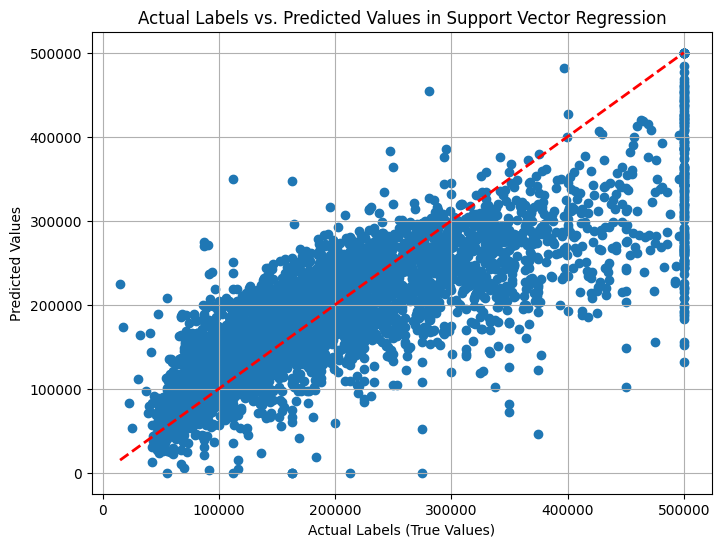

In [17]:
# Test RMSE: 71464.0029355267
# param_grid = [
#     {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
# ]

param_grid = [
    {'kernel': ['linear'], 'C': [10], 'gamma': ['scale']},
]

svm_model = svm.SVR()

grid_search = GridSearchCV(svm_model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           refit=True,
                           verbose=True,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

y_pred = grid_search.predict(X_test)
y_pred = np.minimum(y_pred, 500000)
y_pred = np.maximum(y_pred, 0)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Support Vector Regression")
plt.grid(True)
plt.show()

In [18]:
xgb = GradientBoostingRegressor()

scores = cross_val_score(xgb, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")
# Test RMSE: 52275.951286666284

[52735.03975218 51374.97037973 51467.14770335 54278.51671292
 53124.12671146]
Mean: 52595.96025192825, Std: 1085.7562524473967
Test RMSE: 52242.96427889191


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400}
GradientBoostingRegressor(max_depth=7, n_estimators=400)
45071.92919258782 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400}
Test RMSE: 44500.91583272702


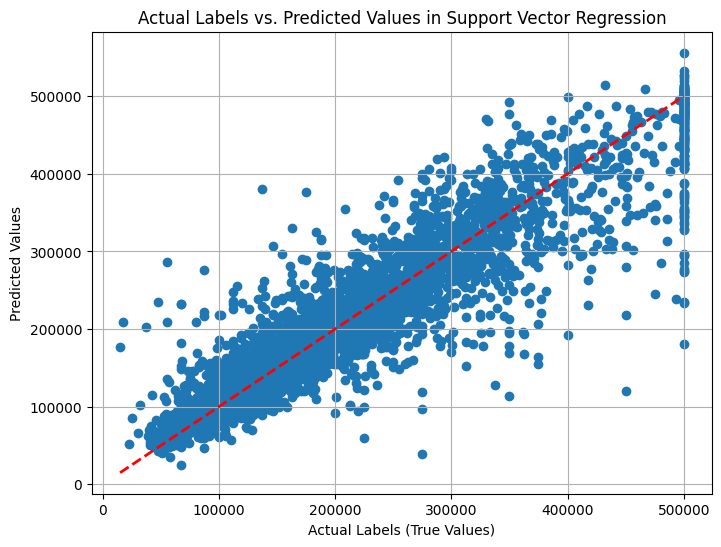

In [20]:
# Test RMSE: 44831.5298339194
# param_grid = [
#     {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
# ]

param_grid = [
    {'learning_rate': [0.1], 'n_estimators': [400], 'max_depth': [7]},
]

xgb = GradientBoostingRegressor()

grid_search = GridSearchCV(xgb, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           refit=True,
                           verbose=True,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

y_pred = grid_search.predict(X_test)
# y_pred = np.minimum(y_pred, 500000)
# y_pred = np.maximum(y_pred, 0)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Support Vector Regression")
plt.grid(True)
plt.show()